# Классификация - и снова в бой!


Сегодня мы поговорим о том, чему же мы научились за последние практики?

Мы освоили основным методы работы как с данными, на основе которых можно решить задачу классификации, так и с моделями, которые это делают! Щикарррно!

Сегодняшняя задачка как всегда несложная, но очень важная - нам предстоит предсказывать болезни сердца!

В вашем распоряжении датасет [Heart Disease UCI](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci). Ваша задача предсказать, есть ли у человека заболевание сердца или нет.

Как всегда, ждем от вас полноценного анализа исходных данных, подготовка необходимой предобработки, feature engineering и поиск лучшего варианта, которный даст наибольшую метрику!

* Задача под звездочкой. Попробуйте реализовать такую систему, которая реже пропускает больных пациентов - мы ведь не хотим больным людям говорить, что они здоровы, хотя это не так?

Мы желаем вам удачи - постарайтесь применить все накопленные знания и, может, чуть больше! Успехов!

# Data loading

## Import libraries

In [107]:
#!pip install opendatasets

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42


## Loading data from Kaggle

In [109]:
df = pd.read_csv('heart_cleveland_upload.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


# Data preprocessing

In [110]:
df.duplicated().sum()

0

### Drop null values

In [111]:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

## EDA

### Feature data distribution

In [112]:
target = 'condition'
features_columns = list(df.drop('condition', axis=1).columns)

In [113]:
numeric_columns = ['oldpeak', 'age', 'trestbps', 'chol', 'thalach']
categorical_columns = list(set(features_columns) - set(numeric_columns))
print(numeric_columns)
print(categorical_columns)

['oldpeak', 'age', 'trestbps', 'chol', 'thalach']
['thal', 'sex', 'restecg', 'ca', 'cp', 'slope', 'exang', 'fbs']


In [114]:
df[features_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.3 KB


In [115]:
def plot_individual_distributions(data, features_columns, bins=30, kde=True):
    n_rows = (len(features_columns) + 1) // 2
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features_columns):
            sns.histplot(data[feature], bins=bins, kde=kde, ax=axes[i], stat='density')
            axes[i].set_title(f'Распределение признака {feature}')
            axes[i].set_xlabel(f'Значение признака {feature}')
            axes[i].set_ylabel('Плотность распределения')
            axes[i].grid(True)  # Добавим сетку на фоне

    # Используем tight_layout для избежания наложения элементов
    plt.tight_layout()
    plt.show()

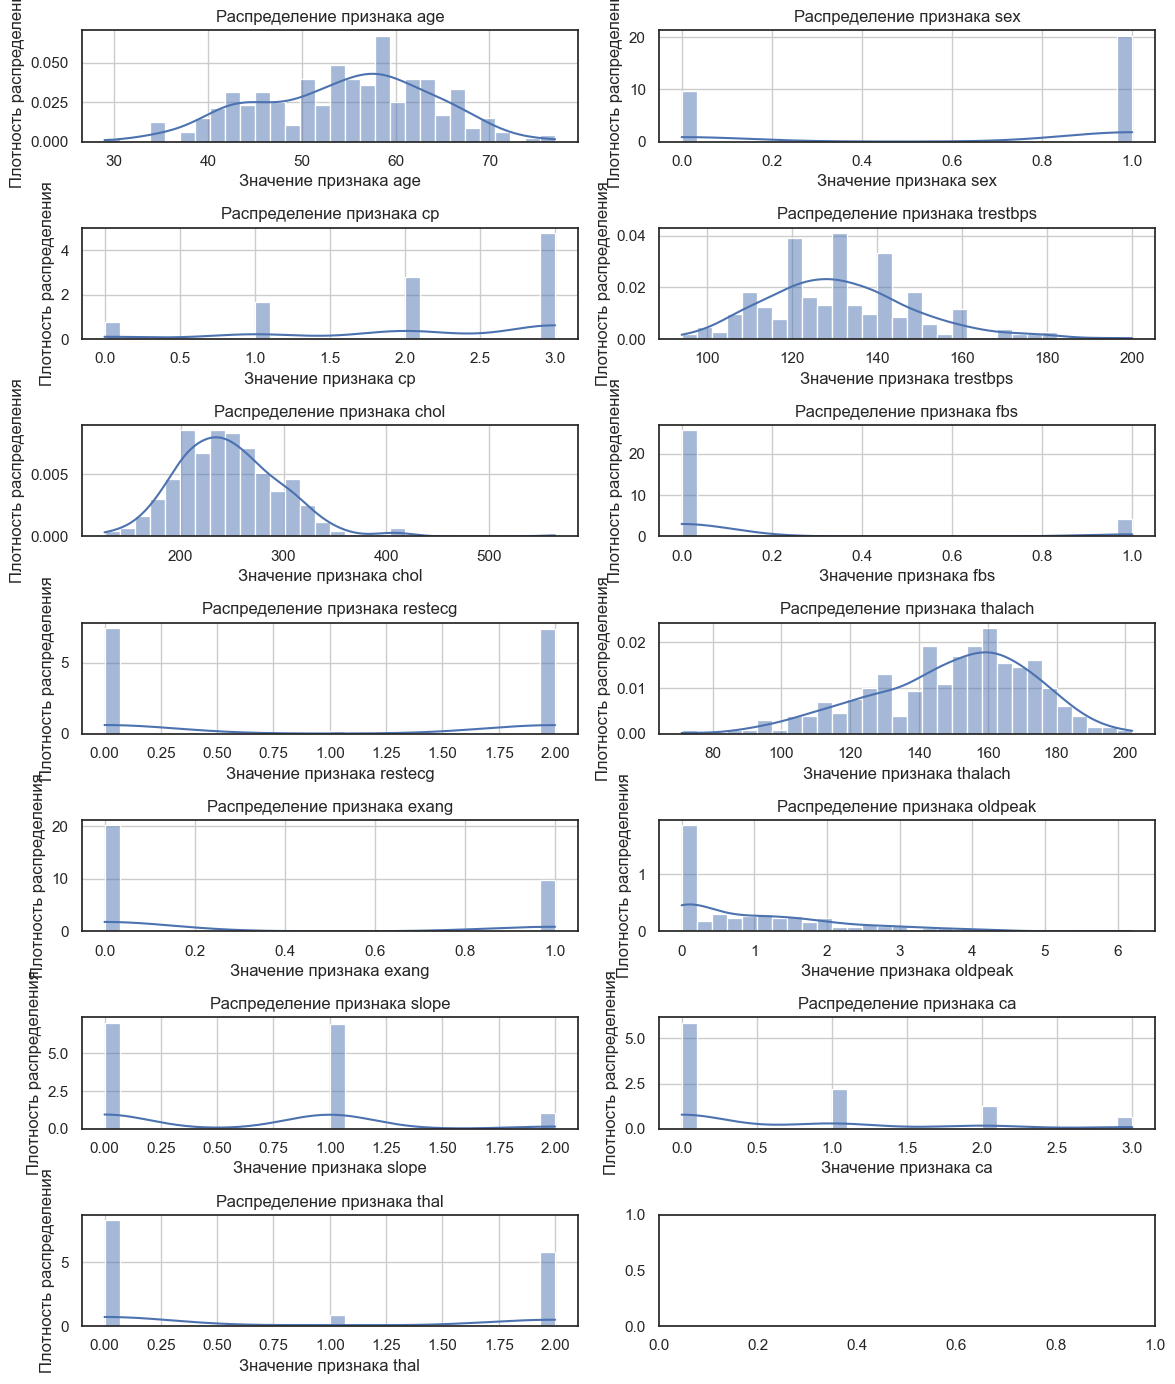

In [116]:
plot_individual_distributions(df, features_columns)

### Clean outliers

In [117]:
def plot_boxplots(data, features_columns):
    # Рассчитаем количество строк и столбцов в сетке
    n_rows = (len(features_columns) + 1) // 2
    n_cols = 2

    # Создадим сетку графиков с яркими цветами
    with sns.color_palette("Set2"):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
        axes = axes.flatten()

        # Итерируемся по признакам и строим boxplot
        for i, feature in enumerate(features_columns):
            sns.boxplot(x=feature, data=data, ax=axes[i])  # Уберем выбросы
            axes[i].set_title(f'Boxplot для признака {feature}')
            axes[i].set_xlabel(f'Значение признака {feature}')
            axes[i].set_ylabel('Значение')
            axes[i].tick_params(axis='x', rotation=45)  # Повернем метки оси x для лучшей читаемости

        # Добавим общий заголовок
        plt.suptitle('Boxplots для различных признаков', y=1.02, fontsize=16)

        # Уменьшим отступы между графиками
        plt.tight_layout()
        plt.show()

In [118]:
def plot_violin_plots(data, columns):
    # Рассчитаем количество строк и столбцов в сетке
    n_rows = (len(columns) + 1) // 2
    n_cols = 2

    # Создадим сетку графиков с яркими цветами и сеткой на фоне
    with sns.color_palette("Set2"):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
        axes = axes.flatten()

        # Итерируемся по признакам и строим violin plot
        for i, column in enumerate(columns):
            sns.violinplot(y=data[column], ax=axes[i], orient='v')
            axes[i].set_title(f'Violin plot для признака {column}')
            axes[i].set_xlabel(f'Значение признака {column}')
            axes[i].set_ylabel('Плотность распределения')
            axes[i].grid(True)  # Добавим сетку на фоне

        # Добавим общий заголовок
        plt.suptitle('Violin Plots для различных признаков', y=1.02, fontsize=16)

        # Используем tight_layout для избежания наложения элементов
        plt.tight_layout()
        plt.show()

In [119]:
def remove_outliers_iqr(data, columns):
    result = data.copy()
    for column in columns:
        Q1 = result[column].quantile(0.25)
        Q3 = result[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        result = result[(result[column] >= lower_bound) & (result[column] <= upper_bound)]
    return result

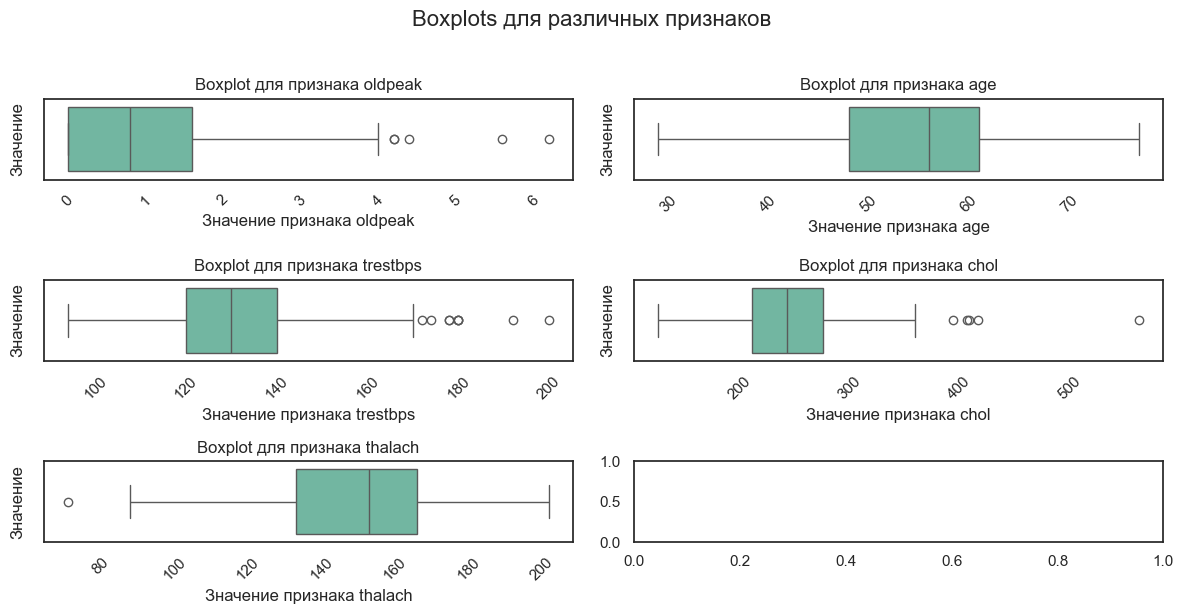

In [120]:
plot_boxplots(df, numeric_columns)

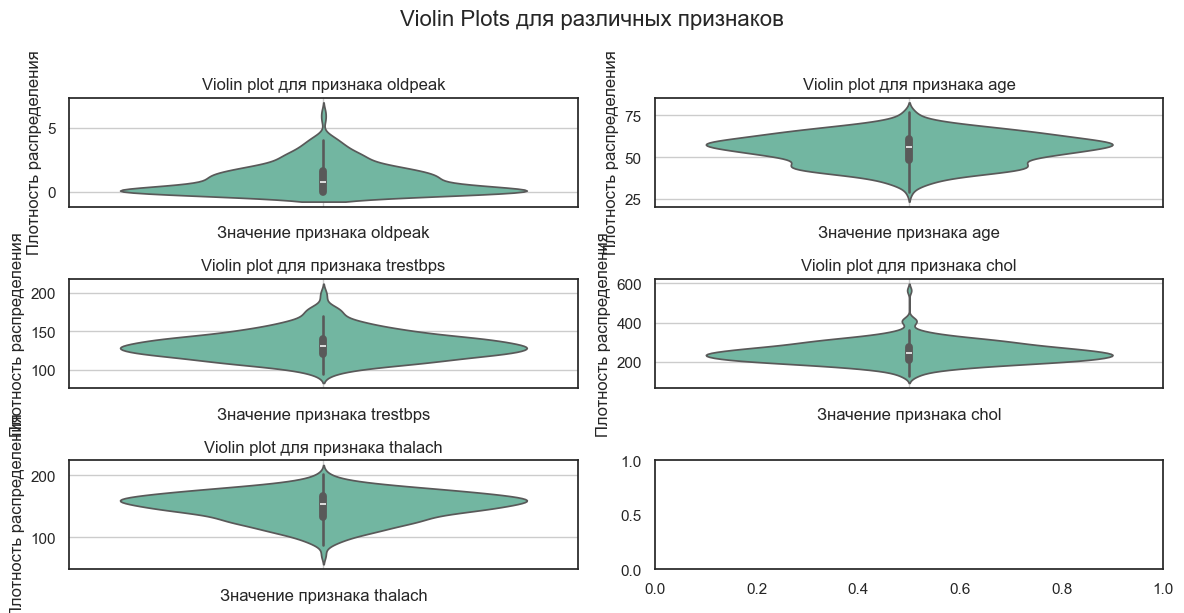

In [121]:
plot_violin_plots(df, numeric_columns)

In [122]:
df_clean = remove_outliers_iqr(df, numeric_columns)

### Target data distribution

In [123]:
def plot_class_pie_chart(data, target):
    class_counts = data[target].value_counts()

    # Получение меток и размеров классов
    labels = class_counts.index
    sizes = class_counts.values

    # Укажем цвета для каждого сегмента
    colors = ['lightcoral', 'lightskyblue']

    # Добавим тень и выделение
    explode = (0.1, 0)

    # Построение круговой диаграммы
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, shadow=True, explode=explode, wedgeprops=dict(width=0.4))
    plt.title('Круговая диаграмма классов')

    # Включение легенды
    plt.legend(title='Метки классов', loc='upper right', bbox_to_anchor=(1, 0.9))

    # Установка аспектного отношения для круглой формы
    plt.axis('equal')

    # Показ графика
    plt.show()

In [124]:
class_counts = df_clean[target].value_counts()
class_counts

condition
0    154
1    124
Name: count, dtype: int64

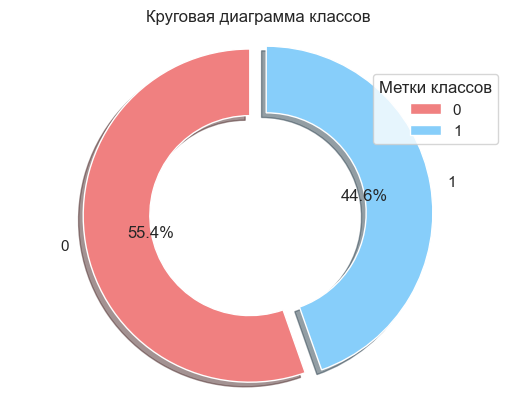

In [125]:
plot_class_pie_chart(df_clean, target)

### Correlation matrix

In [126]:
def plot_correlation_matrix(matrix):
    # Настройка стиля
    sns.set(style="white")

    # Создание фигуры
    plt.figure(figsize=(12, 12))

    # Настройка цветовой карты с белым центром
    cmap = sns.diverging_palette(220, 20, as_cmap=True, center="light")

    # Построение тепловой карты (heatmap)
    ax = sns.heatmap(matrix, cmap=cmap, vmax=.3, center=0,
                    square=True, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .7}, annot_kws={"size": 10})

    plt.title('Матрица корреляции', size=16)
    plt.show()

In [127]:
corr_matrix = df_clean.corr()

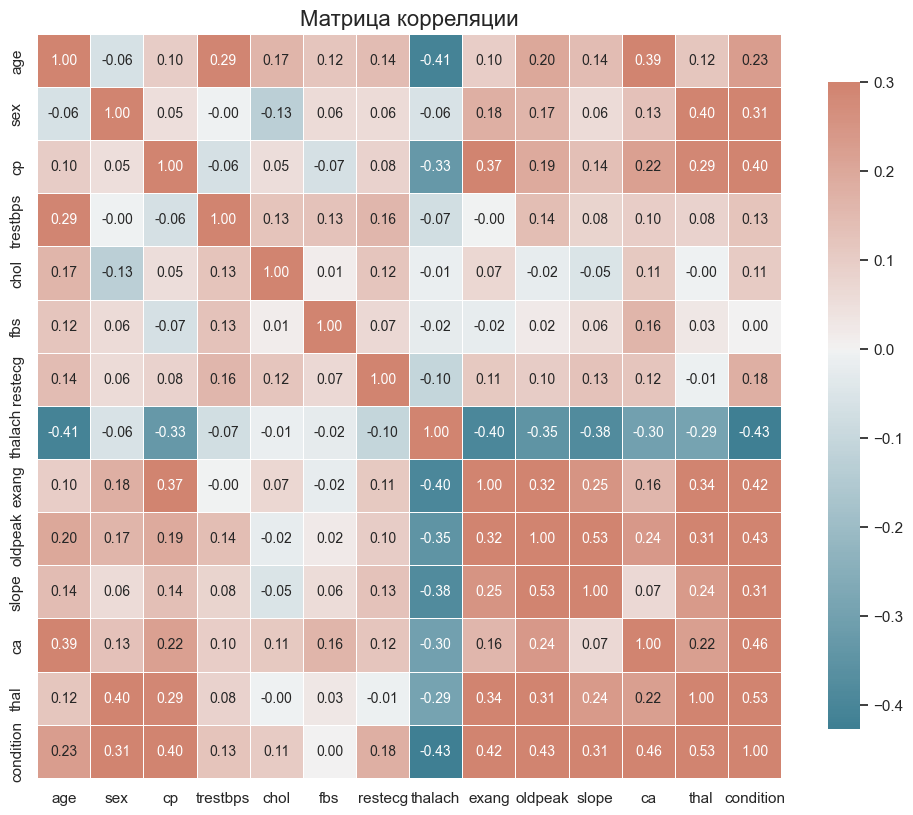

In [128]:
plot_correlation_matrix(corr_matrix)

### Normalize data

In [129]:
scaler = MinMaxScaler()

In [130]:
df_normalized = df_clean.copy()

In [131]:
df_normalized[numeric_columns] = scaler.fit_transform(df_normalized[numeric_columns])

In [132]:
a = pd.get_dummies(df["cp"], prefix="cp",drop_first=True)
b = pd.get_dummies(df["thal"], prefix="thal",drop_first=True)
c = pd.get_dummies(df["slope"], prefix="slope",drop_first=True)
d = pd.get_dummies(df["ca"], prefix="ca",drop_first=True)
e = pd.get_dummies(df["restecg"], prefix="restecg",drop_first=True)
frames = [df_normalized, a, b, c, d, e]
df_to_fit = pd.concat(frames, axis=1)
df_to_fit = df_to_fit.drop(columns=["cp", "thal", "slope","ca","restecg"])
df_to_fit.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,condition,cp_1,...,cp_3,thal_1,thal_2,slope_1,slope_2,ca_1,ca_2,ca_3,restecg_1,restecg_2
0,0.833333,1.0,0.868421,0.461538,1.0,0.377193,0.0,0.025,0.0,False,...,False,False,False,True,False,True,False,False,False,True
1,0.833333,0.0,0.605263,0.482906,0.0,0.552632,0.0,0.450,0.0,False,...,False,False,False,False,False,False,True,False,False,False
2,0.770833,0.0,0.736842,0.427350,0.0,0.228070,0.0,0.650,0.0,False,...,False,False,False,False,True,False,False,False,False,False
3,0.750000,1.0,0.578947,0.666667,1.0,0.754386,0.0,0.350,1.0,False,...,False,False,False,True,False,True,False,False,False,True
4,0.729167,1.0,0.210526,0.363248,0.0,0.491228,1.0,0.450,0.0,False,...,False,False,False,True,False,False,False,False,False,True


# Classification

## Functions

In [133]:
def visualize_roc_auc(model, x_test, y_test):
    y_scores = model.predict_proba(x_test)[:, 1]
    # ROC-кривая и ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    # ROC-кривая
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [134]:
def visualize_confusion_matrix(model, x_test, y_test):
    # Предсказания на тестовых данных
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, cmap='RdYlGn')
    plt.show()

In [135]:
def print_best_params_score(model, x_test, y_test):
    # Получение прогнозов
    y_pred = model.predict(x_test)
    y_scores = model.predict_proba(x_test)[:, 1]

    # Лучшие параметры
    best_params = model.get_params()

    # Оценки модели
    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_scores),
    }

    # Вывод результатов и параметров
    print("Лучшие параметры:", best_params)
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

In [136]:
def get_metrics(y_true, y_pred, prefix):
    return {
        f"{prefix}auc": roc_auc_score(y_true, y_pred),
        f"{prefix}accuracy": accuracy_score(y_true, y_pred),
        f"{prefix}recall": recall_score(y_true, y_pred),
        f"{prefix}precision": precision_score(y_true, y_pred),
        f"{prefix}f1": f1_score(y_true, y_pred),
    }

In [137]:
def get_train_test_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    train_metrics = get_metrics(y_train_true, y_train_pred, "train_")
    test_metrics = get_metrics(y_test_true, y_test_pred, "test_")
    train_metrics.update(test_metrics)
    return train_metrics

In [138]:
def get_train_test_metrics_by_threshold(
        y_train_true, y_train_probs, y_test_true, y_test_probs, threshold
):
    y_train_preds = np.array(y_train_probs >= threshold, dtype="int")
    y_test_preds = np.array(y_test_probs >= threshold, dtype="int")

    return get_train_test_metrics(
        y_train_true, y_train_preds, y_test_true, y_test_preds
    )

In [139]:
def visualize_future_importance(model):
    importances = model.feature_importances_

    indices = list(range(len(importances)))
    indices.sort(key=lambda i: importances[i], reverse=True)

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), [importances[i] for i in indices], align="center")
    plt.xticks(range(len(importances)), model.feature_names_in_[indices], rotation=45)  # Используем имена колонок из модели
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

## Split data

In [140]:
from sklearn.feature_selection import SelectKBest, f_classif

In [141]:
X = df[df.columns.difference(['condition'])]
SKB = SelectKBest(f_classif, k=13).fit(X, np.ravel(df[['condition']]) )
imp_vars_SKB = list(X.columns[SKB.get_support()])
x=df[imp_vars_SKB]
y = df.condition.values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(207, 13) (207,)
(90, 13) (90,)


## Logistic Regression

In [142]:
def visualize_features_importance_log_reg(model, name_columns):
    # Получаем коэффициенты логистической регрессии
    coefficients = model.coef_[0]

    # Создаем список пар (признак, коэффициент) и сортируем его по абсолютным значениям коэффициентов
    sorted_features = sorted(zip(name_columns, np.abs(coefficients)), key=lambda x: x[1])

    # Распаковываем отсортированные пары
    sorted_feature_names, sorted_coefficients = zip(*sorted_features)

    # Строим столбчатую диаграмму важности признаков
    plt.barh(sorted_feature_names, sorted_coefficients)
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.title('Feature Importance in Logistic Regression')
    plt.show()

In [143]:
log_reg = LogisticRegression(random_state=RANDOM_STATE)

In [144]:
log_reg.fit(X_train, y_train)

D:\Jumaev_machine_learning\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [145]:
print_best_params_score(log_reg, X_test, y_test)

Лучшие параметры: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8000
Precision: 0.7609
Recall: 0.8333
F1-score: 0.7955
ROC-AUC: 0.8790


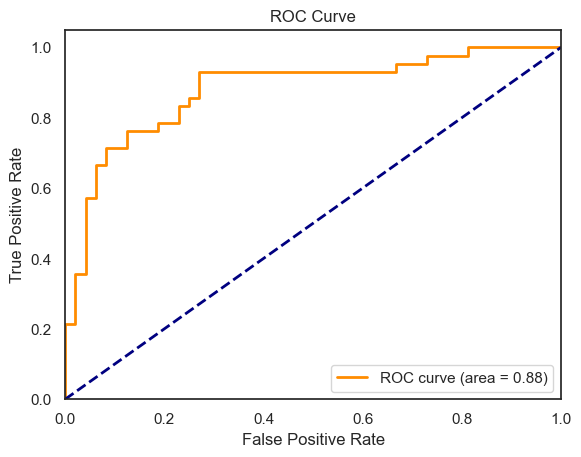

In [146]:
visualize_roc_auc(log_reg, X_test, y_test)

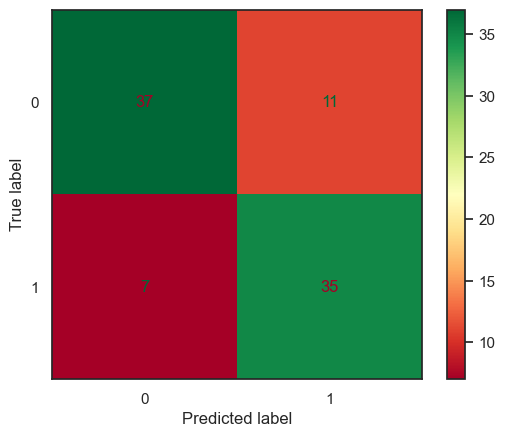

In [147]:
visualize_confusion_matrix(log_reg, X_test, y_test)

### Best model logistic regression

In [148]:
from sklearn.naive_bayes import GaussianNB

In [149]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [150]:
print_best_params_score(gnb, X_test, y_test)

Лучшие параметры: {'priors': None, 'var_smoothing': 1e-09}
Accuracy: 0.8000
Precision: 0.7609
Recall: 0.8333
F1-score: 0.7955
ROC-AUC: 0.8899


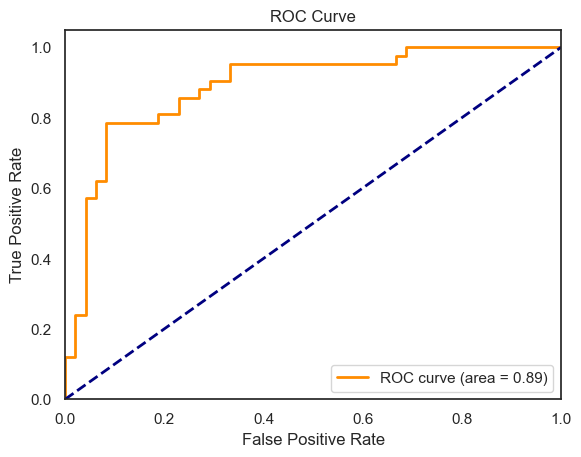

In [151]:
visualize_roc_auc(gnb, X_test, y_test)

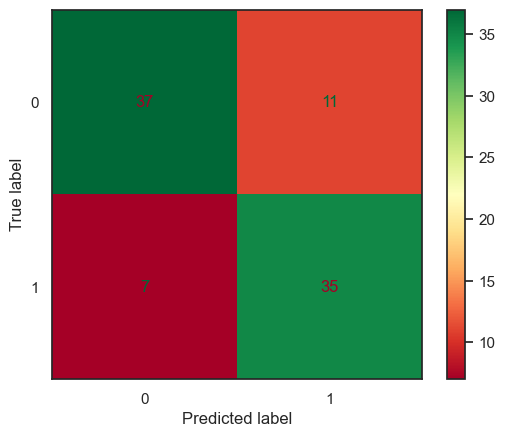

In [152]:
visualize_confusion_matrix(gnb, X_test, y_test)

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [155]:
print_best_params_score(rfc, X_test, y_test)

Лучшие параметры: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8222
Precision: 0.7955
Recall: 0.8333
F1-score: 0.8140
ROC-AUC: 0.9013


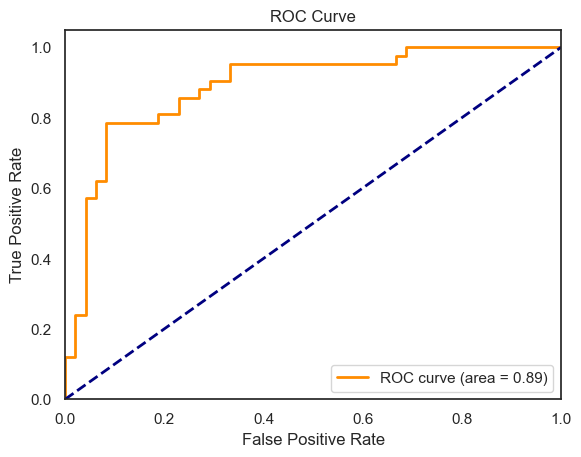

In [156]:
visualize_roc_auc(gnb, X_test, y_test)

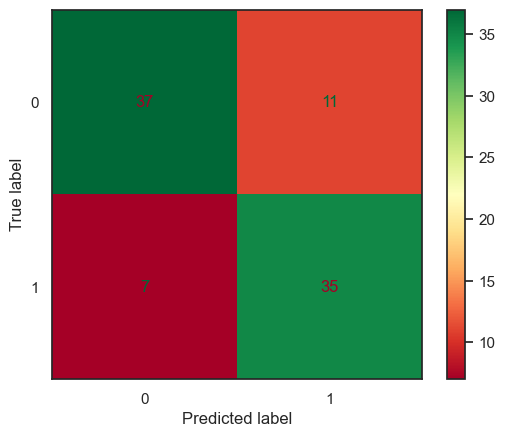

In [157]:
visualize_confusion_matrix(gnb, X_test, y_test)

In [158]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [159]:
print_best_params_score(dtc, X_test, y_test)

Лучшие параметры: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.7333
Precision: 0.6731
Recall: 0.8333
F1-score: 0.7447
ROC-AUC: 0.7396


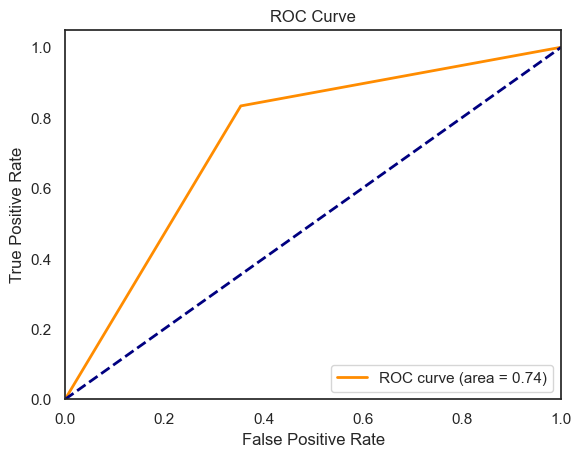

In [161]:
visualize_roc_auc(dtc, X_test, y_test)

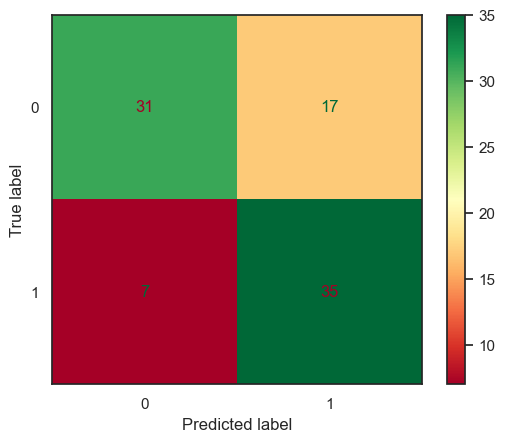

In [162]:
visualize_confusion_matrix(dtc, X_test, y_test)

In [163]:
from sklearn.neighbors import KNeighborsClassifier

In [164]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [165]:
print_best_params_score(knn, X_test, y_test)

Лучшие параметры: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.5889
Precision: 0.5714
Recall: 0.4762
F1-score: 0.5195
ROC-AUC: 0.6369


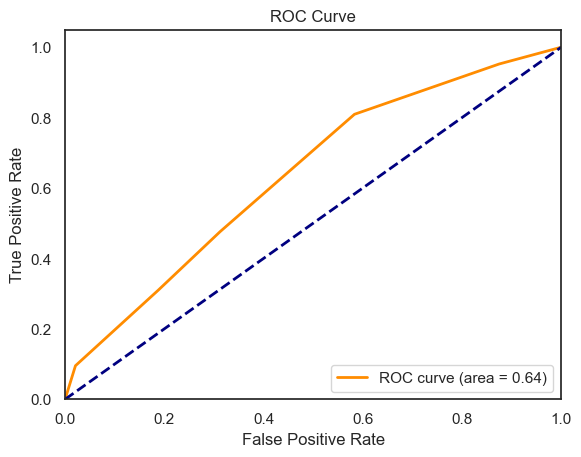

In [166]:
visualize_roc_auc(knn, X_test, y_test)

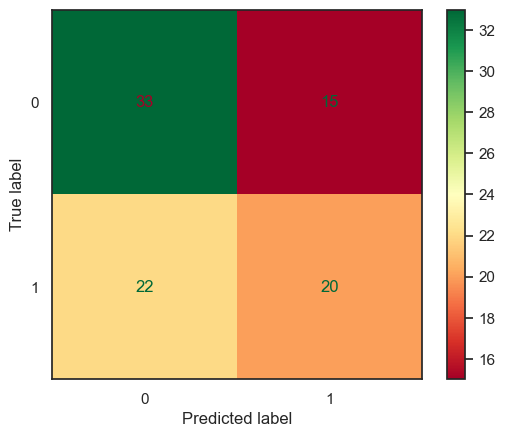

In [167]:
visualize_confusion_matrix(knn, X_test, y_test)